# 9.3 향후 판매량 예측 경진대회 베이스라인 모델
#### 베이스라인 모델 절차
- 모델로는 LightGBM 사용

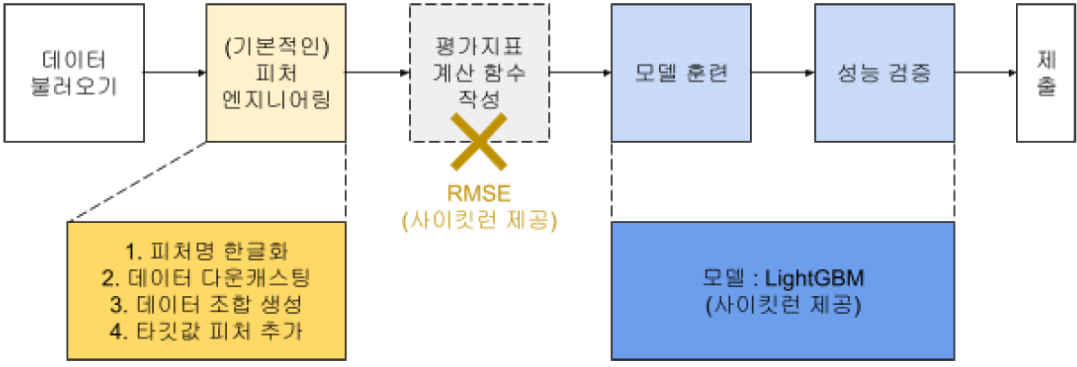

- 이번 장의 핵심은 피처 엔지니어링
 - 베이스라인에서는 간단하게만 할 계획이지만, 단계가 많아서 그림으로 먼저 보고 갑시다!
 
메모리 관리차원 - 다운캐스팅실시

데이터 조합생성 -> 유의미한 데이터 양 늘려보기(행 늘리기)

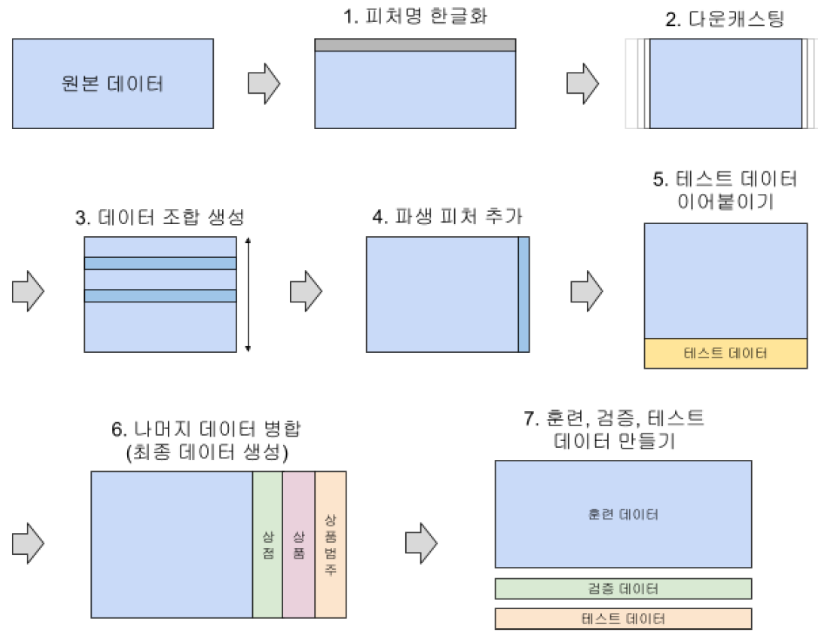


In [137]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') # 경고 문구 생략

# 데이터 경로
data_path = 'C:\\vscode\\kaggle\\dataset\\Predict Future Sales_dat\\'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

## 9.3.1 피처 엔지니어링 I : 피처명 한글화

In [138]:
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

sales_train.head()

# rename 활용 

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [139]:
shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

shops.head()

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [140]:
items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

items.head()

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [141]:
item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

item_categories.head()

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [142]:
test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [143]:
sales_train.info()
# 컬럼명 한글로 잘 바뀌어 있음 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   날짜      object 
 1   월ID     int64  
 2   상점ID    int64  
 3   상품ID    int64  
 4   판매가     float64
 5   판매량     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


## 9.3.2 피처 엔지니어링 II : 데이터 다운캐스팅 (p.628)
- <메모리 관리 기법>
- #### **<font color='orange'> 메모리 관리 필요 </font>**

- 판다스에서 데이터 불러오면 기본적으로 가장 큰 사이즈로 할당함 /  sales_train.info() -> Dtype 확인

-> int64 / float64 등등

- 다운캐스팅(downcasting)이란 더 작은 데이터 타입으로 변환하는 작업
- 금붕어는 금붕어용 어항에서 키워야지, 돌고래용 수족관을 마련할 필요는 없다!
- 메모리 낭비를 막고, 훈련 속도를 빠르게 하려면 모든 데이터를 최대 타입(64)으로 할당할 필요는 없음


- 다운캐스팅 적용

In [144]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all(): # 2.0->2 이런식 정수 변환 
            df[col] = pd.to_numeric(df[col], downcast='integer') #int타입에 맞는 가장 작은 데이터로 축소해라
            # 기본은 64로 할당함 (그릇의 크기를 줄여주는 작업)
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [145]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)
    
# 압축률 출력 

54.2% 압축됨
38.5% 압축됨
54.2% 압축됨
39.8% 압축됨
70.8% 압축됨


## 9.3.3 피처 엔지니어링 III : 데이터 조합 생성(새로운 행 생성)
- 테스트 데이터 피처는 ID 피처를 제외하면 상점ID와 상품ID 피처임
- 우리가 예측해야 하는 값은 각 상점의 상품별 월간 판매량임
- 따라서 월, 상점, 상품별 조합이 필요

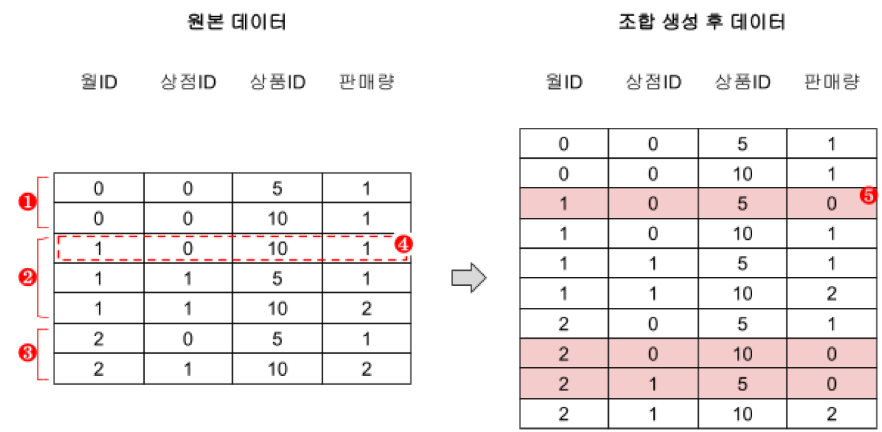

- 조합이란?
 - 원본 데이터의 월ID, 상점ID, 상품ID 피처가 왼쪽과 같다고 하자  
 - ① 월ID가 0일 때 상점ID는 0, 상품ID는 5와 10  
 - ② 월ID가 1일 때 상점ID는 0과 1, 상품ID는 5와 10  
 - ③ 월ID가 2일 때 상점ID는 0과 1, 상품ID는 5와 10  
 - 월ID별로 한 번이라도 등장한 상점ID, 상품ID가 있다면 그것들의 조합을 만듦(오른쪽 표와 같이)  
 - ④ 월ID가 1일 때 상점ID 0인 상점에서는 상품ID가 5인 상품을 팔지 못했기 때문에, 월ID=1, 상점ID=0, 상품ID=5인 데이터가 아예 없음  
 - ⑤ 아예 없는 것보단 판매량이 0이더라도 데이터가 있는 게 나음  

- itertools 패키지가 제공하는 product( ) 함수로 데이터 조합 생성

In [146]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성 
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))
# 모든 경우의 수를 만들어줌

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
# 리스트 타입인 train을 DataFrame 타입으로 변환 
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


- 원래 sales_train 데이터 개수는 2,935,849개 → 조합 생성 후 10,913,850개로 3.7배 늘어남
- 이렇게 만든 train을 훈련 데이터 뼈대로 사용, 여기에 타깃값과 나머지 데이터(shops, items, item_categories) 병합 예정

## 9.3.4 피처 엔지니어링 IV : 타깃값(월간 판매량) 추가
- 타깃값인 각 상점의 상품별 월간 판매량 추가
 - sales_train에 있는 일별 판매량 피처를 그룹화해서 우리가 원하는 타깃값인 각 상점의 상품별 **‘월간’** 판매량 생성
 - #### **<font color='orange'> 타깃값 = date_block_num 피처의 값이 같은 데이터들의 item_cnt_day 값의 합</font>**
 - 앞서 피처 조합을 만들 때 생성한 idx_features = [‘월ID’, ‘상점ID’, ‘상품ID’]를 기준으로 그룹화

In [147]:
idx_features

['월ID', '상점ID', '상품ID']

In [148]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기 
group = sales_train.groupby(idx_features).agg({'판매량': 'sum'})
# 인덱스 재설정
group = group.reset_index()
# 피처명을 '판매량'에서 '월간 판매량'으로 변경
group = group.rename(columns={'판매량': '월간 판매량'})

group

,월ID,상점ID,상품ID,월간 판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


- ‘월간 판매량’을 구했으니 피처명 ‘판매량’도 ‘월간 판매량’으로 변경함

- train과 group을 병합
 - train은 월ID, 상점ID, 상품ID의 조합
 - train에 group을 병합하면 월ID, 상점ID, 상품ID, 월간 판매량 조합을 나타냄

In [149]:
# train과 group 병합하기 -> 최종 데이터셋을 만들어줌 -> 이것을 훈련/검증/테스트 셋으로 구분해서 결과추출
train = train.merge(group, on=idx_features, how='left')

train

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913845,33,21,7635,NaN
10913846,33,21,7638,NaN
10913847,33,21,7640,NaN
10913848,33,21,7632,NaN


- 우리가 원하는 타깃값을 잘 만듦
 - 그런데 타깃값에 결측값이 많음 (결측값은 판매량 정보가 없다는 뜻이므로 추후 0으로 대체)
- 또한, train을 만드는 과정에서 sales_train에 있던 date(날짜) 피처가 사라짐
 #### **<font color='orange'>월별 판매량만 구하면 되니 date 피처 제거 : 필요 없는 date(날짜)피처를 명시적으로 제거한 게 아니라, 병합하는 과정에서 제외하여 같은 효과를 얻음</font>**

- 가비지 컬렉션 -> 메모리상 떠돌아다니는 불필요한 데이터 삭제
 - #### **<font color='orange'> 메모리 관리 필요 </font>**
 - group 데이터는 더 이상 필요 없으니 메모리 절약 차원에서 가비지 컬렉션(garbage collection) 수행 
  - 한정된 메모리를 효율적으로 사용하려면 틈틈이 가비지 컬렉션해주는 게 좋음

In [150]:
import gc # 가비지 컬렉터 불러오기

del group # 더는 사용하지 않는 변수 지정 del sale_train, items 등등 지우고 싶은 변수 넣기 
gc.collect(); # 가비지 컬렉션 수행

## 9.3.5 피처 엔지니어링 V : 테스트 데이터 이어붙이기
- 지금까지 한 작업 되돌아보기
 - 월ID, 상점ID, 상품ID 조합으로 train을 만들고, 여기에 월간 판매량(타깃값)을 추가함

- 테스트 데이터 이어붙이기
 - 뒤이어 shops, items, item_categories 데이터를 병합할 텐데, 이때 테스트 데이터에도 한 번에 병합하는 게 좋기 때문
 - 우선, 테스트 데이터의 월ID 피처 추가 (2015년 10월의 월ID가 33이므로 2015년 11월의 월ID는 34)

In [151]:
train.head()

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN


In [152]:
test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [153]:
test['월ID'] = 34
# test, train 붙이기 위해 test에 월ID인자 추가해줌 

In [154]:
test

,ID,상점ID,상품ID,월ID
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


- 식별자인 ‘ID’ 피처를 제거한 test를 이어붙임

In [155]:
# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)], # test셋에서 id 제거 
                     ignore_index=True, # 기존 인덱스 무시(0부터 새로 시작)
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

# 레프트 조인 -> merge함수 이용 
# 위아래로 이어붙일때 -> concat함수 이용 ( merge도 가능하지만 편리함 )

In [156]:
all_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
11128045,34,45,18454,NaN
11128046,34,45,16188,NaN
11128047,34,45,15757,NaN
11128048,34,45,19648,NaN


- train과 group을 병합할 때 결측값이 많았기 때문에 결측값은 0으로 대체

In [157]:
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
11128045,34,45,18454,0.0
11128046,34,45,16188,0.0
11128047,34,45,15757,0.0
11128048,34,45,19648,0.0


## 9.3.6 피처 엔지니어링 VI : 나머지 데이터 병합(최종 데이터 생성)

- #### **<font color='orange'> shop_id를 기준으로 sales_train과 shops 병합 </font>**
- #### **<font color='orange'> item_id를 기준으로 sales_train과 items 병합 </font>**
- #### **<font color='orange'> item_category_id를 기준으로 sales_train과 item_categories 병합 </font>**
- 즉, 나머지 데이터를 all_data에 병합

- 추가로, 메모리 관리를 위해 데이터 다운캐스팅과 가비지 컬렉션 수행 

In [158]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')
# 세번 연달아 이어붙여줌

# 데이터 다운캐스팅 -> 중간중간에 여러번 해줌 / 새로운 피쳐 생성됐을 수 있기 때문
all_data = downcast(all_data)

# 가비지 컬렉션
del shops, items, item_categories
gc.collect();

# 다운캐스팅, 가비지컬렉션 -> 메모리 절약 실시 

26.4% 압축됨


- 병합한 데이터 확인

In [159]:
all_data

# 상점명 -> 첫 카테고리 도시변수로 생성 , 상품분류명 -> 첫 카테고리 대분류로 만듬 / 각각 사용 피쳐는 삭제
# 이러한 작업은 베이스라인모델이므로 안함 / 추후 성능개선시 실시 

,월ID,상점ID,상품ID,월간 판매량,상점명,상품명,상품분류ID,상품분류명
0,0,59,22154,1,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2552,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,0,59,2554,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,0,59,2555,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,0,59,2564,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео
...,...,...,...,...,...,...,...,...
11128045,34,45,18454,0,"Самара ТЦ ""ПаркХаус""",СБ. Союз 55,55,Музыка - CD локального производства
11128046,34,45,16188,0,"Самара ТЦ ""ПаркХаус""",Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры
11128047,34,45,15757,0,"Самара ТЦ ""ПаркХаус""",НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства
11128048,34,45,19648,0,"Самара ТЦ ""ПаркХаус""",ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD


- 상점명, 상품명, 상품분류명 피처 제거
 - #### **<font color='orange'>문자 데이터이기도 하거니와, 상점ID, 상품ID, 상품분류ID와 각각 상점명, 상품명, 상품분류명이 1:1 매칭되므로 제거 </font>**

In [160]:
all_data = all_data.drop(['상점명', '상품명', '상품분류명'], axis=1)

In [161]:
all_data

,월ID,상점ID,상품ID,월간 판매량,상품분류ID
0,0,59,22154,1,37
1,0,59,2552,0,58
2,0,59,2554,0,58
3,0,59,2555,0,56
4,0,59,2564,0,59
...,...,...,...,...,...
11128045,34,45,18454,0,55
11128046,34,45,16188,0,64
11128047,34,45,15757,0,55
11128048,34,45,19648,0,40


## 9.3.7 피처 엔지니어링 VII : 마무리
- 훈련, 검증, 테스트 데이터로 나누기
 - 훈련 데이터 : 2013년 1월~2015년 9월(월ID=32)
 - 검증 데이터 : 2015년 10월(월ID=33) (**<font color='orange'> 훈련 데이터 중 가장 최근인 2015년 10월 판매 내역을 검증 데이터로 사용</font>**)
 - 테스트 데이터 : 2015년 11월(월ID=34)
 - clip( ) 함수를 활용해 월간 판매량을 0~20 사이로 제한 

In [162]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1) # 월간 판매량은 타겟이므로 드랍 (train에 피쳐만 할당)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)


In [163]:
# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량'] # 월간 판매량인 타깃만 뽑아줌 
y_train = y_train.clip(0, 20) # 타깃값을 0 ~ 20로 제한 -> 경진대회 조건
# clip(0, 20) -> 0보다 작으면 0으로 20보다 크면 20으로 바꿔줌
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']
y_valid = y_valid.clip(0, 20)

In [164]:
del all_data
gc.collect();

## 9.3.8 모델 훈련 및 성능 검증 (p.157)
- LightGBM을 활용해 베이스라인 모델 훈련
 - 범주형 데이터인 상점ID, 상품ID, 상품분류ID 중 고윳값 개수가 너무 많은 상품ID는 범주형 데이터로 취급하지 않음 (LightGBM 문서에 따르면, 고윳값 개수가 너무 많은 범주형 데이터는 수치형 데이터로 취급해야 성능이 더 잘 나옴)

In [165]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse',  # 평가 메트릭 = rmse
          'num_leaves': 255,  # 나뭇잎 노드의 최대 개수
          'learning_rate': 0.01,  # 학습률
          'force_col_wise': True,  # 열 방향 최적화 사용
          'random_state': 10}  # 랜덤 시드

# 실제 데이터에 존재하는 범주형 특성으로 변경해야 합니다.
cat_features = ['상점ID', '상품분류ID']  

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=500,
                      valid_sets=[dtrain, dvalid],  # valid_sets에 리스트 사용
                      categorical_feature=cat_features)

# 훈련 방법은 'train'이며, 'fit'이 아님.
# 학습률, 스텝 길이, num_boost_round는 서로 보완적인 관계를 갖습니다.


[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 10675678, number of used features: 4
[LightGBM] [Info] Start training from score 0.299125


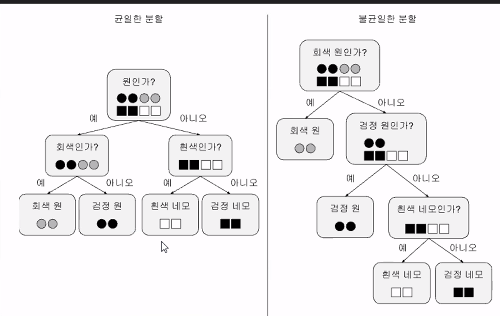

## 9.3.9 예측 및 결과 제출

In [166]:
# 예측
preds = lgb_model.predict(X_test).clip(0, 20)
# 제출 파일 생성
submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

- 끝으로 가비지 컬렉션 수행

In [167]:
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();

- 퍼블릭 점수: 1.08159

시계열 데이터 팁
lag feature 
지난달의 판매량을 새로운 피처로 지정 가능 

데이터 개수 줄어들지만 그걸 상쇄하는 정도의 효과가 있음 

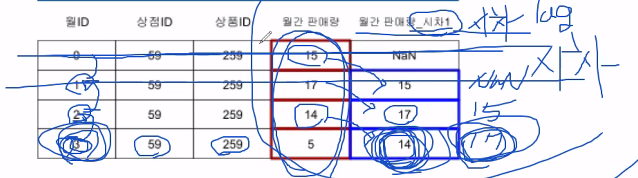